In [1]:
%matplotlib notebook
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import mahotas as mh
from colicoords import iter_subplots
import numpy as np
from symfit import Parameter, Variable, Fit, Model, exp
import os
from addict import Dict

In [2]:
def generate_background(image, median_kernel=11, gaussian_kernel=11, dtype=int):
    assert median_kernel % 2 == 1
    assert image.ndim == 2
    sp_m = medfilt(image, kernel_size=median_kernel)

    #fill corners
    cz = int((median_kernel - 1) / 2)
    sp_m[:cz, :cz] = sp_m[cz, cz]
    sp_m[:cz, -cz:] = sp_m[cz, -cz]
    sp_m[-cz:, -cz:] = sp_m[-cz, -cz]
    sp_m[-cz:, :cz] = sp_m[-cz, cz]

    gf = mh.gaussian_filter(sp_m, gaussian_kernel)

    return gf.astype(dtype)

In [3]:
import symfit
symfit.__version__

'0.5.1'

In [4]:
import colicoords
colicoords.__version__

'0.0.0'

In [5]:
data_dir = r'H:\data\t3ss\20191022_deltaescv_eyfp-escv_aht20' 
#output_dir = r'F:\_processed_big\t3ss\20191002_deltaescv_c41_eyfp-escv_repeat_03'  #moved here
output_dir = r'I:\20191022_deltaescv_eyfp-escv_aht20'  #tempdir, fasterspeed

In [6]:
df_dir = r'H:\data\t3ss\20191009_c41_eyfp-escv_AHT30_agarose_medium_repeats'

In [7]:
dfg100 = tifffile.imread(os.path.join(df_dir, 'Image', 'dark_g100.tif'))
dfg500 = tifffile.imread(os.path.join(df_dir, 'Image', 'dark_g500.tif'))
dfg100.mean() - dfg500.mean()

93.47394943237305

# epec_yfp-escv_aht20

In [9]:
td = Dict()
fname = 'epec_yfp-escv_aht20'

In [10]:
td.bf_raw = tifffile.imread(os.path.join(data_dir, fname, '_BF_140_.tif'))

In [11]:
td.bf_raw.shape

(51, 512, 512)

<IPython.core.display.Javascript object>


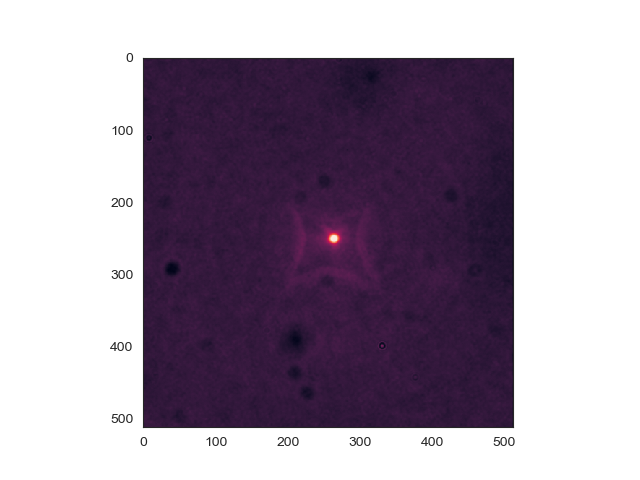

In [12]:
td.median = np.median(td.bf_raw, axis=0)
td.median.shape
plt.figure()
plt.imshow(td.median)

In [13]:
td.bf_flat = (td.bf_raw - dfg100) / (td.median - dfg100)

<IPython.core.display.Javascript object>


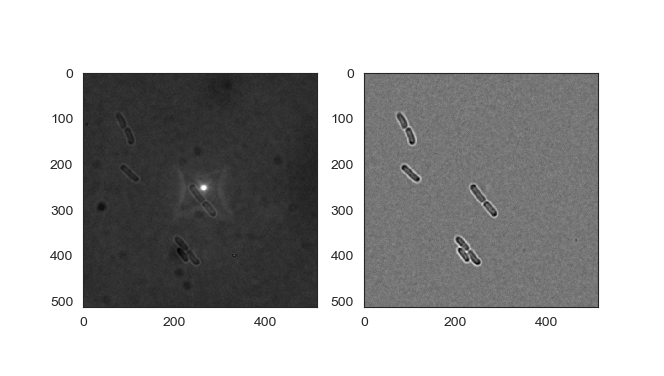

In [14]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(td.bf_raw, cmap='gray')
ax2.iter_imshow(td.bf_flat, cmap='gray')
fig.display()

In [15]:
np.save(os.path.join(output_dir, fname + '_BF_flat.npy'), td.bf_flat)

## Beamprofile

In [20]:
images = ['Image_061.tif', 'Image_066.tif', 'Image_063.tif', 'Image_065.tif']#, 'Image_028.tif', 'Image_029.tif', 'Image_030.tif', 'Image_031.tif', 'Image_032.tif', 'Image_033.tif']
bps = [tifffile.imread(os.path.join(data_dir, 'Image', f)) for f in images]

In [21]:
bp = np.stack(bps)
bp.shape

(4, 512, 512)

<IPython.core.display.Javascript object>


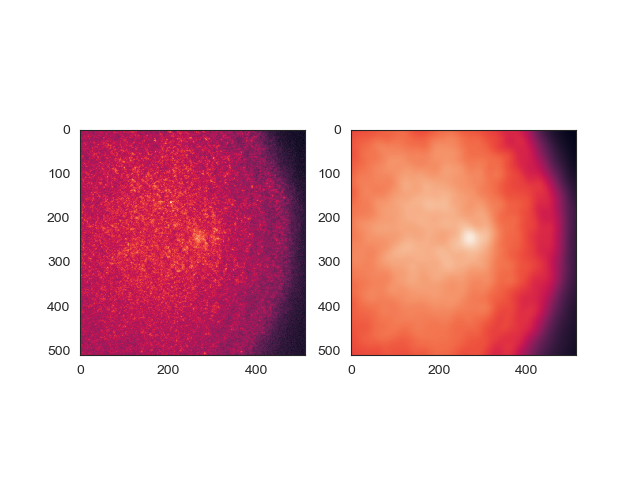

In [22]:
smoothed = generate_background(np.mean(bp, axis=0))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.mean(bp, axis=0))
ax2.imshow(smoothed)

In [24]:
bp_final = smoothed / smoothed.max()

In [25]:
tifffile.imsave(os.path.join(output_dir, 'beamprofile.tif'), bp_final)

In [26]:
np.save(os.path.join(output_dir, 'beamprofile.npy'), bp_final)

In [51]:
cells = ['c41_yfp-escv_escrstu_aht30', 'c41_yfp-escv_escrstu_aht30_iptg20', 'c41_yfp-escv_only_aht30']
files = ['514_g100', '514_g500']
dfs = [dfg100, dfg500]

for c in cells:
    for df, f in zip(dfs, files):
        arr = tifffile.imread(os.path.join(data_dir, c, f + '.tif')).astype(float)
        new_arr = arr.reshape(-1, *arr.shape[2:])
        new_arr -= df.mean()
        new_arr /= bp_final
        print(c, f, new_arr.min(), new_arr.max())
        np.save(os.path.join(output_dir, '{}_{}.npy'.format(c, f)), new_arr)

c41_yfp-escv_escrstu_aht30 514_g100 -25.66574876210672 73122.91084531041
c41_yfp-escv_escrstu_aht30 514_g500 122.90742905657763 139982.07503817254
c41_yfp-escv_escrstu_aht30_iptg20 514_g100 113.95150373060272 70797.62598743012
c41_yfp-escv_escrstu_aht30_iptg20 514_g500 607.3873740425422 143593.08100906792
c41_yfp-escv_only_aht30 514_g100 57.63198144382509 129594.26933040952
c41_yfp-escv_only_aht30 514_g500 311.99385927573195 147379.52466970577


<IPython.core.display.Javascript object>


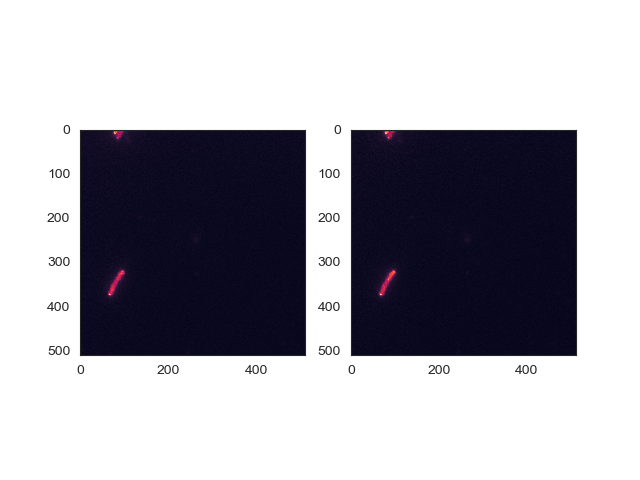

In [52]:
c = 'c41_yfp-escv_escrstu_aht30'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()

<IPython.core.display.Javascript object>


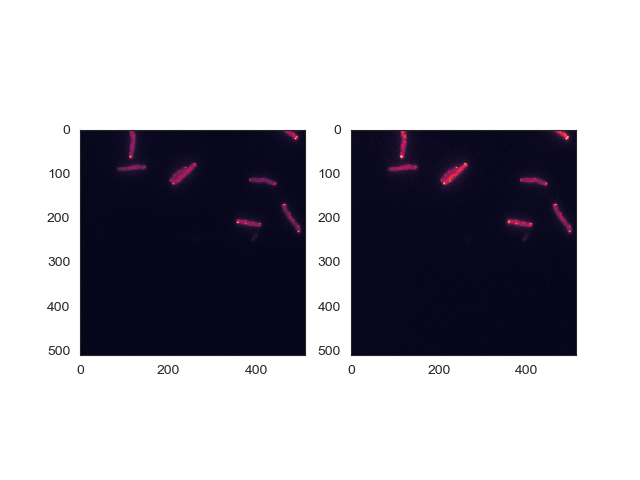

In [53]:
c = 'c41_yfp-escv_escrstu_aht30_iptg20'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()

<IPython.core.display.Javascript object>


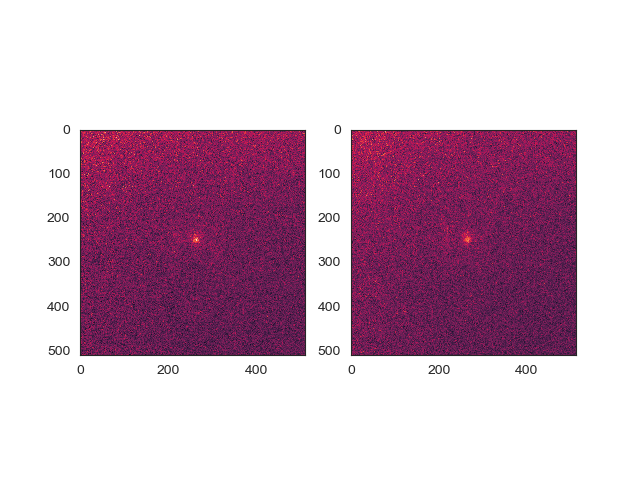

In [54]:
c = 'c41_yfp-escv_only_aht30'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()